In [ ]:
!pip install open3d

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import numpy as np
import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from scipy import io as scipy_io
import os
import open3d as o3d

In [ ]:
!unzip "/content/drive/MyDrive/modelnet_views.zip"

Streaming output truncated to the last 5000 lines.
  inflating: classes/table/train/table_0315.off/table_0315.1.png  
  inflating: classes/table/train/table_0315.off/table_0315.5.png  
  inflating: classes/table/train/table_0315.off/table_0315.7.png  
  inflating: classes/table/train/table_0315.off/table_0315.0.png  
  inflating: classes/table/train/table_0315.off/table_0315.4.png  
   creating: classes/table/train/table_0389.off/
  inflating: classes/table/train/table_0389.off/table_0389.2.png  
  inflating: classes/table/train/table_0389.off/table_0389.5.png  
  inflating: classes/table/train/table_0389.off/table_0389.3.png  
  inflating: classes/table/train/table_0389.off/table_0389.8.png  
  inflating: classes/table/train/table_0389.off/table_0389.11.png  
  inflating: classes/table/train/table_0389.off/table_0389.10.png  
  inflating: classes/table/train/table_0389.off/table_0389.7.png  
  inflating: classes/table/train/table_0389.off/table_0389.0.png  
  inflating: classes/table/

In [ ]:
!unzip "/content/drive/MyDrive/modelnet_pc.zip"

Streaming output truncated to the last 5000 lines.
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0255.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0509.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0362.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0292.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0552.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0164.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0195.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0481.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0322.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0404.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0401.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0044.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0488.ply  
  inflating: ModelNet40_ply/bookshelf/train/bookshelf_0537.ply  
  inflating: ModelNet40_ply/bookshelf/t

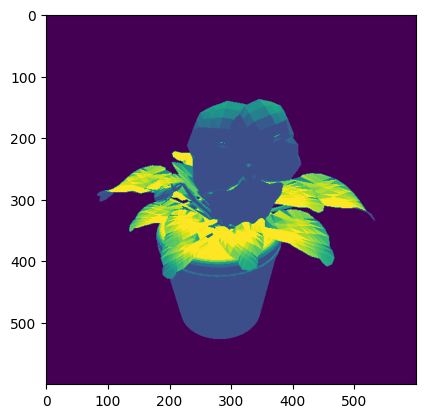

In [ ]:
img = read_image("/content/classes/flower_pot/train/flower_pot_0002.off/flower_pot_0002.0.png")
plt.imshow(img.permute(1, 2, 0))

In [ ]:
input_file = "/content/ModelNet40_ply/airplane/train/airplane_0001.ply"
pcd = o3d.io.read_point_cloud(input_file)

In [ ]:
# o3d.visualization.draw_plotly([pcd])

In [ ]:
point_cloud_numpy = np.asarray(pcd.points)
point_cloud_numpy.shape

(2048, 3)

In [ ]:
np.min(point_cloud_numpy, axis = 0)

array([-141.78339  , -241.20619  ,    1.5151669])

In [ ]:
# pcd.points = o3d.utility.Vector3dVector(point_cloud_numpy[::2, :])
# o3d.visualization.draw_plotly([pcd])

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, split, img_ds_path = "./classes", pt_cloud_ds_path = "./ModelNet40_ply"):
    self.img_ds_path = img_ds_path
    self.pt_cloud_ds_path = pt_cloud_ds_path
    self.split = split
    self.data = []
    models = os.listdir(img_ds_path)
    for model_name in models:
      model_versions = os.listdir(f"{img_ds_path}/{model_name}/{split}")
      for version in model_versions:
        sample = version.split(".")[0]
        img_path = f"./classes/{model_name}/{split}/{version}/{sample}.0.png"
        point_cloud_path = f"{pt_cloud_ds_path}/{model_name}/{split}/{sample}.ply"
        self.data.append((img_path, point_cloud_path))
    self.resize_transform = torchvision.transforms.Resize((192, 256))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path, pt_cloud_path = self.data[idx]

    pcd = o3d.io.read_point_cloud(pt_cloud_path)
    pcd_np_arr = np.asarray(pcd.points)
    idx = np.random.randint(0, pcd_np_arr.shape[0], size = 1024)
    pt_cloud_arr = torch.tensor(pcd_np_arr[idx]).to(torch.float32)

    img_arr = read_image(img_path)
    img_resize = self.resize_transform(img_arr)

    # point cloud coords range roughly from -250 to 250 so I will divide by 500
    return img_resize.to(torch.float32) / 255.0 , pt_cloud_arr / 500.0



In [ ]:
train_ds = CustomDataset("train")

torch.Size([1, 192, 256]) torch.Size([1024, 3])


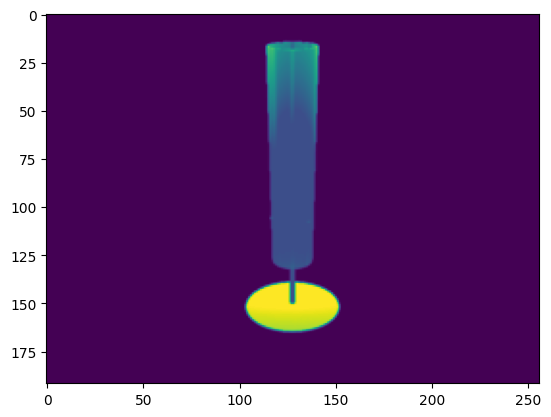

In [ ]:
x, y = train_ds[1]
print(x.shape, y.shape)
plt.imshow(x.permute(1, 2, 0))

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(y)
o3d.visualization.draw_plotly([pcd])

In [ ]:
class PointOutNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, 3)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(16, 16, 3)
    self.relu2 = nn.ReLU()

    # self.fc1 = nn.Linear(16, 16)
    # self.fc2 = nn.Linear(16, 16)

    self.conv3 = nn.Conv2d(32, 32, 3)
    self.relu3 = nn.ReLU()
    self.conv4 = nn.Conv2d(32, 32, 3)
    self.relu4 = nn.ReLU()
    self.conv5 = nn.Conv2d(32, 32, 3, stride = 2)
    self.relu5 = nn.ReLU()

    self.conv6 = nn.Conv2d(32, 64, 3)
    self.relu6 = nn.ReLU()
    self.conv7 = nn.Conv2d(64, 64, 3)
    self.relu7 = nn.ReLU()
    self.conv8 = nn.Conv2d(64, 64, 3, stride = 2)
    self.relu8 = nn.ReLU()

    self.conv9 = nn.Conv2d(64, 128, 3)
    self.relu9 = nn.ReLU()
    self.conv10 = nn.Conv2d(128, 128, 3)
    self.relu10 = nn.ReLU()
    self.conv11 = nn.Conv2d(128, 128, 3, stride = 2)
    self.relu11 = nn.ReLU()

    self.conv12 = nn.Conv2d(128, 256, 3)
    self.relu12 = nn.ReLU()
    self.conv13 = nn.Conv2d(256, 256, 3)
    self.relu13 = nn.ReLU()
    self.conv14 = nn.Conv2d(256, 256 , 3, stride = 2)
    self.relu14 = nn.ReLU()

    self.conv15 = nn.Conv2d(256, 512, 3)
    self.relu15 = nn.ReLU()
    self.conv16 = nn.Conv2d(512, 512, 3)
    self.relu16 = nn.ReLU()
    self.conv17 = nn.Conv2d(512, 512, 3, padding = 'same')
    self.relu17 = nn.ReLU()
    self.conv18 = nn.Conv2d(512, 512, 3, padding = 'same')
    self.relu18 = nn.ReLU()


    self.conv19 = nn.Conv2d(512, 1024, 3)
    self.relu19 = nn.ReLU()

    self.flat20 = nn.Flatten()
    self.fc20 = nn.Linear(5120, 1024*3)


  def forward(self, x, rv):
        # First block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)

        # Fully connected layers
        #rv = self.fc1(rv)
        #rv = self.fc2(rv)
        #print(x.shape, rv.shape)
        x = torch.cat((x, rv), 1)


        # Second block
        #x = x.view(x.size(0), 32, 32, 32)  # Reshape to match the input shape of the next layer
        x = self.conv3(x)
        x = self.relu3(x)
        #print(x.shape)

        x = self.conv4(x)
        x = self.relu4(x)
        #print(x.shape)

        x = self.conv5(x)
        x = self.relu5(x)


        # Third block
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.conv7(x)
        x = self.relu7(x)
        x = self.conv8(x)
        x = self.relu8(x)


        # Fourth block
        x = self.conv9(x)
        x = self.relu9(x)
        x = self.conv10(x)
        x = self.relu10(x)
        x = self.conv11(x)
        x = self.relu11(x)

        # Fifth block
        x = self.conv12(x)
        x = self.relu12(x)
        x = self.conv13(x)
        x = self.relu13(x)
        x = self.conv14(x)
        x = self.relu14(x)


        # Sixth block
        x = self.conv15(x)
        x = self.relu15(x)

        x = self.conv16(x)
        x = self.relu16(x)

        x = self.conv17(x)
        x = self.relu17(x)

        x = self.conv18(x)
        x = self.relu18(x)

        # Seventh block
        x = self.conv19(x)
        x = self.relu19(x)

        x = x.view(x.size(0), -1) #self.flat20(x) #x.view(x.size(0), -1)  # Flatten the input
        x = self.fc20(x)

        return x.reshape(-1, 1024, 3)

In [ ]:
model = PointOutNet()

In [ ]:
out = model(train_ds[0][0][None, ...], torch.rand((1, 16, 188, 252)))
out.shape

torch.Size([1, 1024, 3])

In [115]:
def calc_nearest_neighbor_distance(t1, t2):
    """
    t1 shape (B, N_points, 3)
    t2 shape (B, N_points, 3)

    returns the index of the nearest neighbor from t2 to each point in t1
            shape (B, N_points, 1)
    """
    B, N_points, C = t1.shape
    t1 = t1[..., None]
    t2 = t2.permute(0, 2, 1)[:, torch.newaxis, :, :]

    d = (t1 - t2).permute(0, 1, 3, 2)
    d = torch.sum(d**2, axis = 3)
    return torch.min(d, axis = 2)

def calc_chamfer_distance(y_true, y_pred, return_idx = False):
    d1, idx1 = calc_nearest_neighbor_distance(y_true, y_pred)
    d2, idx2 = calc_nearest_neighbor_distance(y_pred, y_true)
    if return_idx:
       return torch.sum(d1 + d2) , (idx1, idx2)
    return torch.sum(d1 + d2)

def earth_mover_distance(y_true, y_pred):
    return torch.mean(torch.square(
        torch.cumsum(y_true, dim=-1) - torch.cumsum(y_pred, dim=-1)), dim=-1).mean()

In [116]:
t1 = torch.tensor([[[0, 0, 0], [1, 1, 1]]])
t2 = torch.tensor([[[0, 1, 1], [1, 0, 0]]])
calc_chamfer_distance(t1, t2)

tensor(4)

In [117]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.75)

In [118]:
BATCH_SIZE = 4
EPOCHS = 500

In [119]:
train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle= False)

In [120]:
torch.cuda.empty_cache()

In [121]:
IS_CUDA_AVAILABLE = torch.cuda.is_available()
if IS_CUDA_AVAILABLE:
  model = model.cuda()

In [122]:
loss_history = []

for i in range(EPOCHS):
  epoch_loss = 0
  for x, y in train_dataloader:

    optimizer.zero_grad()
    rv = torch.zeros((BATCH_SIZE, 16, 188, 252))#torch.rand((BATCH_SIZE, 16, 188, 252))

    if IS_CUDA_AVAILABLE:
      x = x.cuda()
      rv = rv.cuda()
      y = y.cuda()

    y_pred = model(x, rv)

    loss =  calc_chamfer_distance(y, y_pred) + earth_mover_distance(y, y_pred) #torch.sum((y_pred - y)**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    epoch_loss += loss.item()
    break
  loss_history.append(epoch_loss)
  if i % 50 == 0:
    print(f"epoch: {i} --- Loss: {epoch_loss}")


epoch: 0 --- Loss: 0.4372478127479553
epoch: 50 --- Loss: 10.31627368927002
epoch: 100 --- Loss: 0.7401151061058044
epoch: 150 --- Loss: 0.5086106657981873
epoch: 200 --- Loss: 0.42982667684555054
epoch: 250 --- Loss: 0.43674764037132263
epoch: 300 --- Loss: 0.4233265817165375
epoch: 350 --- Loss: 0.42444196343421936
epoch: 400 --- Loss: 0.4153123199939728
epoch: 450 --- Loss: 0.43515095114707947


Text(0, 0.5, 'Loss')

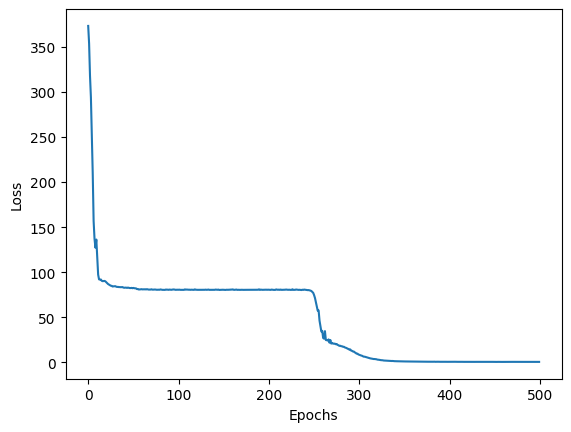

In [105]:
plt.plot(np.arange(len(loss_history)), loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [138]:
x, y_true = train_ds[1]
if IS_CUDA_AVAILABLE:
  pred = model(x[None, ...].cuda(), torch.zeros((1, 16, 188, 252)).cuda())
else:
  pred = model(x[None, ...], torch.zeros((1, 16, 188, 252)))
pred = pred.squeeze().cpu().detach().numpy()
print(type(pred), pred.shape)

<class 'numpy.ndarray'> (1024, 3)


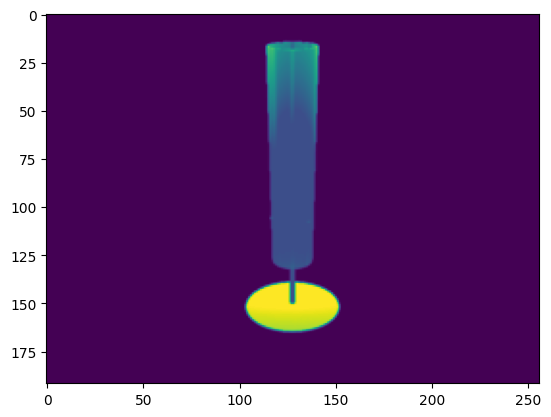

In [139]:
plt.imshow(x.squeeze())

In [140]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(y_true)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, 0.0005)
o3d.visualization.draw_plotly([mesh])


In [129]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pred)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, 0.00015)
o3d.visualization.draw_plotly([mesh])
